In [15]:
pip install torch-geometric faiss-cpu

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

import numpy as np
import scipy.io as sio
from skimage.morphology import opening, disk
import seaborn as sns
import matplotlib.pyplot as plt
import faiss

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.manifold import TSNE

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [17]:
data_path = '/content/drive/MyDrive/Micro-Hybrid Model for IndianPines in One Day/Indian_pines.mat'
gt_path = '/content/drive/MyDrive/Micro-Hybrid Model for IndianPines in One Day/Indian_pines_gt.mat'

In [18]:
full_data_cube = sio.loadmat(data_path)['indian_pines']
labels = sio.loadmat(gt_path)['indian_pines_gt']

In [19]:
def select_best_bands(data_cube, num_bands_to_select=15):
    num_total_bands = data_cube.shape[2]
    informativeness_scores = []
    print("\nStarting morphological band selection...")
    for i in range(num_total_bands):
        band_image = data_cube[:, :, i]
        se_sizes = range(2, 11, 2)
        profile_images = [band_image]
        for size in se_sizes:
            se = disk(size)
            opened_image = opening(band_image, se)
            profile_images.append(opened_image)
        stacked_profile = np.stack(profile_images, axis=-1)
        pixel_wise_std = np.std(stacked_profile, axis=-1)
        score = np.mean(pixel_wise_std)
        informativeness_scores.append(score)
    ranked_band_indices = np.argsort(informativeness_scores)[::-1]
    selected_indices = np.sort(ranked_band_indices[:num_bands_to_select])
    print(f"Band selection complete. Selected indices: {selected_indices}")
    selected_bands_data = data_cube[:, :, selected_indices]
    return selected_indices, selected_bands_data

selected_indices, selected_data = select_best_bands(full_data_cube, num_bands_to_select=15)


Starting morphological band selection...
Band selection complete. Selected indices: [21 22 23 24 27 28 32 33 34 38 40 41 42 43 56]


In [20]:
def prepare_data_patches(data_cube, ground_truth, patch_size=9):
    print("\nPreparing patch-based data...")
    half_patch = patch_size // 2
    padded_data = np.pad(data_cube, ((half_patch, half_patch), (half_patch, half_patch), (0, 0)), mode='constant')
    patches, patch_labels = [], []
    height, width = ground_truth.shape
    for i in range(height):
        for j in range(width):
            label = ground_truth[i, j]
            if label != 0:
                patch = padded_data[i:i + patch_size, j:j + patch_size, :]
                patches.append(patch)
                patch_labels.append(label)
    X = np.array(patches)
    y = np.array(patch_labels)
    X = np.transpose(X, (0, 3, 1, 2))
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.30, random_state=0, stratify=y)
    print("Patch-based data preparation complete.")
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_data_patches(selected_data, labels, patch_size=9)


Preparing patch-based data...
Patch-based data preparation complete.


In [21]:
def create_knn_graph_data(data_cube, ground_truth, k=10):
    print("\nConstructing k-NN graph data...")
    node_coords = np.argwhere(ground_truth > 0)
    num_nodes = len(node_coords)
    node_features = data_cube[node_coords[:, 0], node_coords[:, 1], :]
    scaler = StandardScaler()
    node_features_scaled = scaler.fit_transform(node_features)
    node_labels = ground_truth[node_coords[:, 0], node_coords[:, 1]]

    print("Building k-NN graph with Faiss...")
    index = faiss.IndexFlatL2(node_features_scaled.shape[1])
    index.add(node_features_scaled.astype(np.float32))
    distances, neighbor_indices = index.search(node_features_scaled.astype(np.float32), k + 1)

    edge_list = []
    for i in range(num_nodes):
        for j in range(1, k + 1):
            neighbor_idx = neighbor_indices[i, j]
            edge_list.append([i, neighbor_idx])

    print(f"Graph has {num_nodes} nodes and {len(edge_list)} edges.")

    x = torch.from_numpy(node_features_scaled).float()
    y = torch.from_numpy(node_labels).long()
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

    node_indices = np.arange(num_nodes)
    train_indices, test_indices = train_test_split(
        node_indices, train_size=0.30, random_state=0, stratify=y.numpy())

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[train_indices] = True
    test_mask[test_indices] = True

    graph_data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)

    print("Graph data construction complete.")
    return graph_data

graph_data = create_knn_graph_data(selected_data, labels, k=10)


Constructing k-NN graph data...
Building k-NN graph with Faiss...
Graph has 10249 nodes and 102490 edges.
Graph data construction complete.


In [22]:
def train_and_evaluate_cnn_rnn(model, model_name, lr, epochs, weighted_loss=False):
    print(f"\n--- Training and Evaluating {model_name} ---")
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).long()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).long()

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    if weighted_loss:
        all_possible_labels = np.arange(1, 17)
        class_weights_skl = compute_class_weight(
            class_weight='balanced', classes=all_possible_labels, y=y_train)
        class_weights = torch.zeros(17)
        class_weights[all_possible_labels] = torch.tensor(class_weights_skl, dtype=torch.float)
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

    print("\nFinished Training. Evaluating...")
    model.eval()
    all_preds, all_targets = [], []
    penultimate_features = []

    feature_layer = None
    if hasattr(model, 'fc_layers'):
        feature_layer = model.fc_layers
    elif hasattr(model, 'classifier'):
        feature_layer = model.classifier

    hook = None
    if feature_layer and isinstance(feature_layer, nn.Sequential):
        target_layer = None
        for layer in reversed(feature_layer):
            if isinstance(layer, nn.Linear):
                target_layer = layer
                break

        if target_layer:
            def hook_fn(mod, inp, out):
                penultimate_features.append(inp[0].detach().cpu().numpy())
            hook = target_layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    if hook:
        hook.remove()

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    oa = accuracy_score(all_targets, all_preds)
    kappa = cohen_kappa_score(all_targets, all_preds)
    cm = confusion_matrix(all_targets, all_preds)
    per_class_accuracy = cm.diagonal() / (cm.sum(axis=1) + 1e-9)
    aa = np.mean(per_class_accuracy)

    print(f"\n--- Results for {model_name} ---")
    print(f"Overall Accuracy (OA): {oa:.4f}")
    print(f"Average Accuracy (AA): {aa:.4f}")
    print(f"Kappa Coefficient: {kappa:.4f}\n")
    print("Classification Report:")
    print(classification_report(all_targets, all_preds, zero_division=0))

    final_features = np.vstack(penultimate_features) if penultimate_features else None
    return model, all_preds, all_targets, final_features

In [23]:
def train_and_evaluate_gcn(model, model_name):
    print(f"\n--- Training and Evaluating {model_name} ---")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    data = graph_data.to(device)

    unique_labels = np.unique(data.y.cpu().numpy())
    class_weights_skl = compute_class_weight('balanced', classes=unique_labels, y=data.y.cpu().numpy())
    class_weights = torch.zeros(17)
    class_weights[unique_labels] = torch.tensor(class_weights_skl, dtype=torch.float)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    for epoch in range(1, 201):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss.item():.4f}')

    print("\nFinished Training. Evaluating...")
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)

    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = pred[data.test_mask].cpu().numpy()

    oa = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    per_class_accuracy = cm.diagonal() / (cm.sum(axis=1) + 1e-9)
    aa = np.mean(per_class_accuracy)

    print(f"\n--- Results for {model_name} ---")
    print(f"Overall Accuracy (OA): {oa:.4f}")
    print(f"Average Accuracy (AA): {aa:.4f}")
    print(f"Kappa Coefficient: {kappa:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

In [24]:
class Baseline3DCNN(nn.Module):
    def __init__(self, input_channels, num_classes, patch_size=9):
        super(Baseline3DCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(3, 3, 3), padding=1),
            nn.ReLU(),
            nn.Conv3d(8, 16, kernel_size=(3, 3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 1)),
        )
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, input_channels, patch_size, patch_size)
            dummy_output = self.conv_layers(dummy_input)
            flattened_size = dummy_output.numel()
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

baseline_model = Baseline3DCNN(input_channels=15, num_classes=17, patch_size=9)
_, _, _, baseline_features = train_and_evaluate_cnn_rnn(baseline_model, "Baseline 3D-CNN", lr=0.001, epochs=25)


--- Training and Evaluating Baseline 3D-CNN ---
Epoch [1/25], Loss: 44.7126
Epoch [2/25], Loss: 2.3643
Epoch [3/25], Loss: 2.3512
Epoch [4/25], Loss: 2.2810
Epoch [5/25], Loss: 2.2006
Epoch [6/25], Loss: 2.1419
Epoch [7/25], Loss: 2.0637
Epoch [8/25], Loss: 2.0355
Epoch [9/25], Loss: 2.0274
Epoch [10/25], Loss: 1.8758
Epoch [11/25], Loss: 1.6776
Epoch [12/25], Loss: 1.6167
Epoch [13/25], Loss: 1.5503
Epoch [14/25], Loss: 1.5528
Epoch [15/25], Loss: 1.5594
Epoch [16/25], Loss: 1.7921
Epoch [17/25], Loss: 1.5714
Epoch [18/25], Loss: 1.4755
Epoch [19/25], Loss: 1.4614
Epoch [20/25], Loss: 1.4249
Epoch [21/25], Loss: 1.4040
Epoch [22/25], Loss: 1.3874
Epoch [23/25], Loss: 1.3672
Epoch [24/25], Loss: 1.3454
Epoch [25/25], Loss: 1.3934

Finished Training. Evaluating...

--- Results for Baseline 3D-CNN ---
Overall Accuracy (OA): 0.5218
Average Accuracy (AA): 0.3379
Kappa Coefficient: 0.4237

Classification Report:
              precision    recall  f1-score   support

           1       0.00

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, width * height)
        attention = F.softmax(torch.bmm(query, key), dim=-1)
        value = self.value(x).view(batch_size, -1, width * height)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return out

class HybridCNN_Attention(nn.Module):
    def __init__(self, input_channels, num_classes, patch_size=9):
        super(HybridCNN_Attention, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(3, 3, 3), padding=1),
            nn.ReLU(),
            nn.Conv3d(8, 16, kernel_size=(3, 3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 1))
        )
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, input_channels, patch_size, patch_size)
            dummy_output = self.conv_layers(dummy_input)
            conv_out_shape = dummy_output.shape
            attention_in_channels = conv_out_shape[1] * conv_out_shape[2]
            fc_in_features = dummy_output.numel()
        self.norm = nn.BatchNorm2d(attention_in_channels)
        self.attention = SelfAttention(attention_in_channels)
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fc_in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv_layers(x)
        b, c, d, h, w = x.shape
        x = x.view(b, c * d, h, w)
        x = self.norm(x)
        x = self.attention(x)
        x = self.fc_layers(x)
        return x

hybrid_model_improved = HybridCNN_Attention(input_channels=15, num_classes=17, patch_size=9)
hybrid_model_final, hybrid_preds, hybrid_targets, hybrid_features = train_and_evaluate_cnn_rnn(
    hybrid_model_improved, "Improved Hybrid CNN with Attention", lr=0.0005, epochs=50)


--- Training and Evaluating Improved Hybrid CNN with Attention ---
Epoch [1/50], Loss: 1.8509
Epoch [2/50], Loss: 1.6201
Epoch [3/50], Loss: 1.4078
Epoch [4/50], Loss: 1.2885
Epoch [5/50], Loss: 1.1980
Epoch [6/50], Loss: 1.0706
Epoch [7/50], Loss: 1.0032
Epoch [8/50], Loss: 0.8824
Epoch [9/50], Loss: 0.7822
Epoch [10/50], Loss: 0.7924
Epoch [11/50], Loss: 0.7029
Epoch [12/50], Loss: 0.6103
Epoch [13/50], Loss: 0.6298
Epoch [14/50], Loss: 0.5926
Epoch [15/50], Loss: 0.6988
Epoch [16/50], Loss: 0.5452
Epoch [17/50], Loss: 0.4881
Epoch [18/50], Loss: 0.5229
Epoch [19/50], Loss: 0.5439
Epoch [20/50], Loss: 0.4103
Epoch [21/50], Loss: 0.4406
Epoch [22/50], Loss: 0.7324
Epoch [23/50], Loss: 0.5916
Epoch [24/50], Loss: 0.5685
Epoch [25/50], Loss: 0.4495
Epoch [26/50], Loss: 0.4288
Epoch [27/50], Loss: 0.5940
Epoch [28/50], Loss: 0.4699
Epoch [29/50], Loss: 0.4883
Epoch [30/50], Loss: 0.3796
Epoch [31/50], Loss: 0.3606
Epoch [32/50], Loss: 0.4406
Epoch [33/50], Loss: 0.3799
Epoch [34/50], Lo

In [26]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

gcn_model = GCN(in_channels=15, hidden_channels=128, out_channels=17)
train_and_evaluate_gcn(gcn_model, "k-NN GCN Model")


--- Training and Evaluating k-NN GCN Model ---
Epoch: 020, Loss: 2.2478
Epoch: 040, Loss: 1.9268
Epoch: 060, Loss: 1.7314
Epoch: 080, Loss: 1.5996
Epoch: 100, Loss: 1.4862
Epoch: 120, Loss: 1.3862
Epoch: 140, Loss: 1.3309
Epoch: 160, Loss: 1.2889
Epoch: 180, Loss: 1.2276
Epoch: 200, Loss: 1.2047

Finished Training. Evaluating...

--- Results for k-NN GCN Model ---
Overall Accuracy (OA): 0.4206
Average Accuracy (AA): 0.5473
Kappa Coefficient: 0.3647

Classification Report:
              precision    recall  f1-score   support

           1       0.26      0.66      0.37        32
           2       0.39      0.26      0.31      1000
           3       0.31      0.29      0.30       581
           4       0.27      0.70      0.39       166
           5       0.36      0.51      0.42       338
           6       0.76      0.63      0.69       511
           7       0.09      0.80      0.17        20
           8       0.84      0.69      0.75       335
           9       0.07      0.57  

In [27]:
class RecursiveGatedModel(nn.Module):
    def __init__(self, num_classes, patch_size=9):
        super(RecursiveGatedModel, self).__init__()
        self.cnn_features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, patch_size, patch_size)
            dummy_output = self.cnn_features(dummy_input)
            cnn_out_features = dummy_output.numel()
        self.gru = nn.GRU(
            input_size=cnn_out_features, hidden_size=64, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(64 * 2, num_classes)
    def forward(self, x):
        B, D, H, W = x.shape
        x = x.view(B * D, 1, H, W)
        x = self.cnn_features(x)
        x = x.view(B, D, -1)
        _, h_n = self.gru(x)
        h_n = h_n.permute(1, 0, 2)
        h_n = h_n.contiguous().view(B, -1)
        out = self.classifier(h_n)
        return out

gated_model_improved = RecursiveGatedModel(num_classes=17, patch_size=9)
train_and_evaluate_cnn_rnn(
    gated_model_improved, "Improved Recursive Gated (CNN-GRU) Model", lr=0.0005, epochs=50, weighted_loss=True)


--- Training and Evaluating Improved Recursive Gated (CNN-GRU) Model ---
Epoch [1/50], Loss: 2.6604
Epoch [2/50], Loss: 2.1885
Epoch [3/50], Loss: 1.8020
Epoch [4/50], Loss: 1.5445
Epoch [5/50], Loss: 1.2963
Epoch [6/50], Loss: 1.1488
Epoch [7/50], Loss: 0.9878
Epoch [8/50], Loss: 0.9390
Epoch [9/50], Loss: 0.8413
Epoch [10/50], Loss: 0.7538
Epoch [11/50], Loss: 0.7353
Epoch [12/50], Loss: 0.6987
Epoch [13/50], Loss: 0.6414
Epoch [14/50], Loss: 0.6025
Epoch [15/50], Loss: 0.5649
Epoch [16/50], Loss: 0.5600
Epoch [17/50], Loss: 0.5236
Epoch [18/50], Loss: 0.5080
Epoch [19/50], Loss: 0.5024
Epoch [20/50], Loss: 0.5028
Epoch [21/50], Loss: 0.4764
Epoch [22/50], Loss: 0.4634
Epoch [23/50], Loss: 0.4685
Epoch [24/50], Loss: 0.3965
Epoch [25/50], Loss: 0.3769
Epoch [26/50], Loss: 0.3701
Epoch [27/50], Loss: 0.3549
Epoch [28/50], Loss: 0.3705
Epoch [29/50], Loss: 0.3500
Epoch [30/50], Loss: 0.3509
Epoch [31/50], Loss: 0.3234
Epoch [32/50], Loss: 0.3328
Epoch [33/50], Loss: 0.3514
Epoch [34/5

(RecursiveGatedModel(
   (cnn_features): Sequential(
     (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): ReLU()
     (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (gru): GRU(64, 64, batch_first=True, bidirectional=True)
   (classifier): Linear(in_features=128, out_features=17, bias=True)
 ),
 array([11,  3,  6, ...,  2, 11, 11]),
 array([11,  2,  6, ...,  2, 10, 11]),
 None)


--- Generating Final Visualizations for the Best Model ---


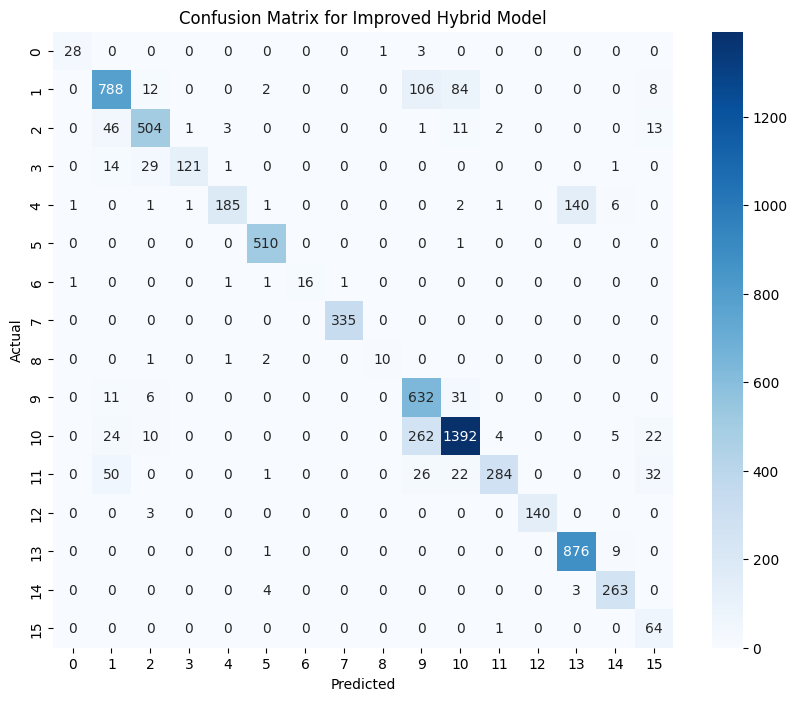

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7175 samples in 0.001s...
[t-SNE] Computed neighbors for 7175 samples in 0.842s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7175
[t-SNE] Computed conditional probabilities for sample 2000 / 7175
[t-SNE] Computed conditional probabilities for sample 3000 / 7175
[t-SNE] Computed conditional probabilities for sample 4000 / 7175
[t-SNE] Computed conditional probabilities for sample 5000 / 7175
[t-SNE] Computed conditional probabilities for sample 6000 / 7175
[t-SNE] Computed conditional probabilities for sample 7000 / 7175
[t-SNE] Computed conditional probabilities for sample 7175 / 7175
[t-SNE] Mean sigma: 7.549017
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.107933
[t-SNE] KL divergence after 300 iterations: 2.182052


/tmp/ipython-input-28-3471983835.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y_test, cmap=plt.cm.get_cmap("jet", 16), marker='.')
/tmp/ipython-input-28-3471983835.py:19: UserWarning: Mismatched number of handles and labels: len(handles) = 8 len(labels) = 16
  plt.legend(handles=scatter.legend_elements()[0], labels=range(1, 17))


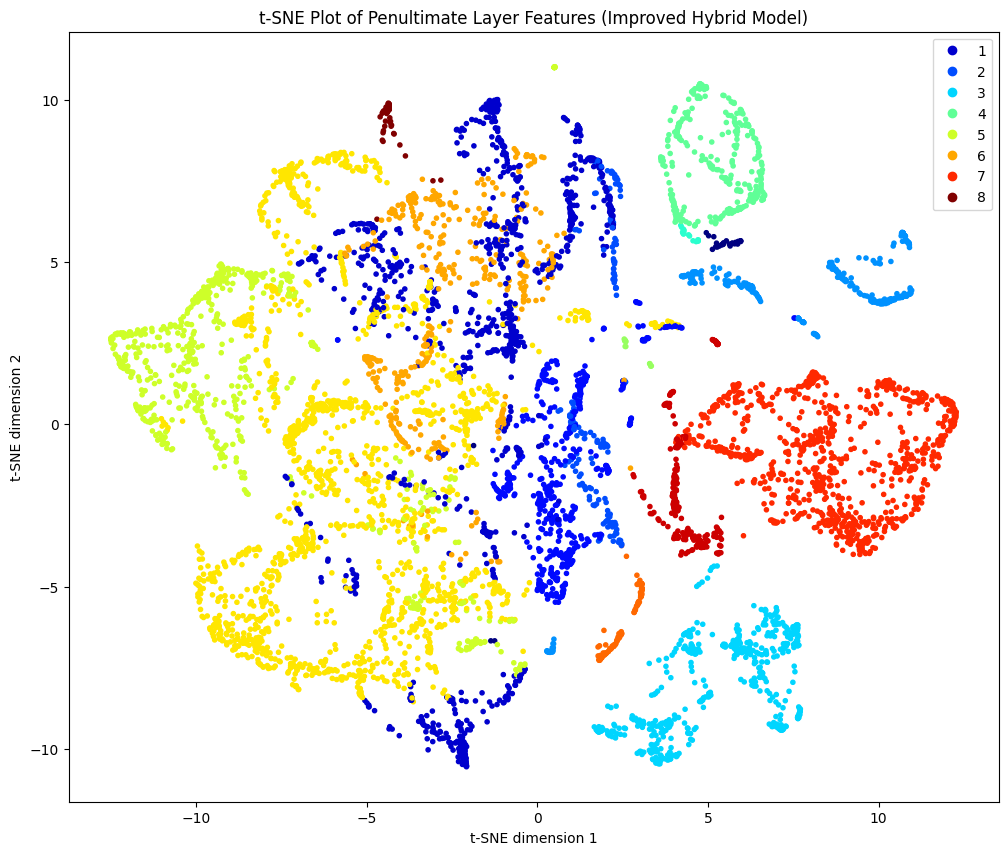

/tmp/ipython-input-28-3471983835.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.imshow(prediction_map, cmap=plt.cm.get_cmap("jet", 17))


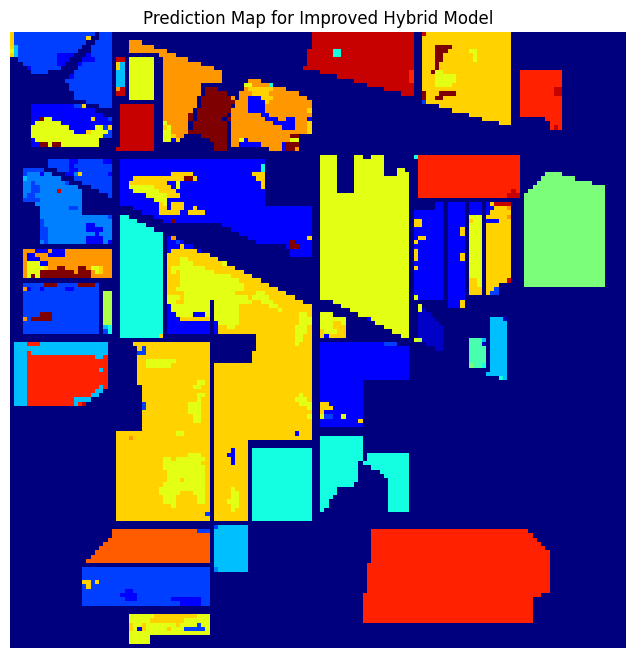

In [28]:
print("\n--- Generating Final Visualizations for the Best Model ---")

cm = confusion_matrix(hybrid_targets, hybrid_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Improved Hybrid Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png')
plt.show()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(hybrid_features)
plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y_test, cmap=plt.cm.get_cmap("jet", 16), marker='.')
plt.title('t-SNE Plot of Penultimate Layer Features (Improved Hybrid Model)')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend(handles=scatter.legend_elements()[0], labels=range(1, 17))
plt.savefig('tsne_plot.png')
plt.show()

def predict_full_image(model, data_cube, patch_size=9):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    half_patch = patch_size // 2
    padded_data = np.pad(data_cube, ((half_patch, half_patch), (half_patch, half_patch), (0, 0)), mode='constant')
    prediction_map = np.zeros((data_cube.shape[0], data_cube.shape[1]))
    for i in range(data_cube.shape[0]):
        for j in range(data_cube.shape[1]):
            if labels[i,j] == 0:
                continue
            patch = padded_data[i:i + patch_size, j:j + patch_size, :]
            patch = np.transpose(patch, (2, 0, 1))
            patch_tensor = torch.from_numpy(patch).float().unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(patch_tensor)
                _, predicted_class = torch.max(output.data, 1)
                prediction_map[i, j] = predicted_class.item()
    return prediction_map

prediction_map = predict_full_image(hybrid_model_final, selected_data)
plt.figure(figsize=(8, 8))
plt.imshow(prediction_map, cmap=plt.cm.get_cmap("jet", 17))
plt.title('Prediction Map for Improved Hybrid Model')
plt.axis('off')
plt.savefig('prediction_map.png')
plt.show()